## Show the segmentation

In [ ]:
from ast import mod
import numpy as np
from omegaconf import DictConfig, OmegaConf
from typing import Dict, Tuple

import torch
import matplotlib.pyplot as plt

import data
from data.datasets import MedicalDecathlonDataset, BrainTumourDataset
from models.unet3d import UNet3D

# ras+ ORIENTATION
# class imbalance

# task_name = "Task04_Hippocampus"
task_name = "Task01_BrainTumour"
inference_model_name = "2025-03-29_01-04-49"

model_dir = f"trained_models/unet3d/{task_name}/{inference_model_name}"
model_path = f"{model_dir}/best_model.pth"

cfg = OmegaConf.load(f"{model_dir}/config.yaml")

if not isinstance(cfg, DictConfig):
    raise TypeError("cfg must be a DictConfig.")

# dataset = MedicalDecathlonDataset(cfg, phase="test")
dataset = BrainTumourDataset(cfg, phase='test')

model = UNet3D(
    in_channels=1,
    num_classes=cfg.dataset.num_classes,
    n_filters=cfg.model.n_filters,
    dropout=cfg.training.dropout,
    batch_norm=True,
    ds=cfg.model.deep_supervision,
    inference_fusion_mode=cfg.model.deep_supervision.inference_fusion_mode,
    depth=cfg.model.depth,
    deep_supervision_levels=cfg.model.deep_supervision.levels
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, map_location="cpu"))
model.to(device)  # Move the model to the appropriate device
model.eval()


#samples idx list to check: (6,)
sample_idx = 392

image, gt = dataset[sample_idx]  # image: (C, D, H, W), gt: (D, H, W)

# Add batch dimension and move to device
image_batch = image.unsqueeze(0).to(device)  # shape: (1, C, D, H, W)

# Run inference
with torch.no_grad():
    output = model(image_batch)
    # If model returns deep supervision outputs, take the final prediction
    if isinstance(output, (tuple, list)):
        output = output[0]
    # Get predicted labels: (B, D, H, W)
    pred = torch.argmax(output, dim=1).squeeze(0).cpu()  

# Convert tensors to numpy arrays for visualization
# Remove channel dimension from image for visualization: (D, H, W)
image_np = image.squeeze(0).cpu().numpy()
gt_np = gt.cpu().numpy()
pred_np = pred.numpy()

# Choose 3 slices evenly spaced along the depth dimension
num_slices = 66
depth = image_np.shape[0]
slice_indices = [int(depth * i / (num_slices + 1)) for i in range(1, num_slices + 1)]

# Create subplots: one row per slice and 3 columns for image, ground truth, and prediction
fig, axes = plt.subplots(nrows=num_slices, ncols=3, figsize=(12, 4 * num_slices))
for i, slice_idx in enumerate(slice_indices):
    slice_2d = image_np[slice_idx]
    # slice_2d = np.rot90(slice_2d)
    axes[i, 0].imshow(slice_2d, cmap="gray")
    axes[i, 0].set_title(f"Image Slice {slice_idx}")
    
    gt_2d = gt_np[slice_idx]
    # gt_2d = np.rot90(gt_2d)
    axes[i, 1].imshow(gt_2d, cmap="grey", vmin=0, vmax=cfg.dataset.num_classes - 1)

    axes[i, 1].set_title(f"Ground Truth Slice {slice_idx}")
    pred_2d = pred_np[slice_idx]
    # pred_2d = np.rot90(pred_2d)
    axes[i, 2].imshow(pred_2d, cmap="grey", vmin=0, vmax=cfg.dataset.num_classes - 1)
    axes[i, 2].set_title(f"Prediction Slice {slice_idx}")

    # for ax in axes[i]:
    #     ax.axis("off")



plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.__config__ import show

import matplotlib.pyplot as plt
import numpy as np

def show_prediction(image, gt_mask, pred_mask, slice_idx=None, class_id=1):
    gt_binary = (gt_mask == class_id)
    pred_binary = (pred_mask == class_id)

    if slice_idx is None:
        z_coords = np.where(gt_binary)[0]
        slice_idx = z_coords[len(z_coords)//2] if len(z_coords) > 0 else gt_mask.shape[0] // 2

    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(image[slice_idx], cmap='gray')
    plt.title("MRI Slice")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(gt_binary[slice_idx], cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(pred_binary[slice_idx], cmap='gray')
    plt.title("Prediction")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    error_map = np.logical_xor(gt_binary[slice_idx], pred_binary[slice_idx])
    plt.imshow(error_map, cmap='Reds')
    plt.title("Error Map")
    plt.axis('off')

    plt.suptitle(f"Class {class_id} - Slice {slice_idx}", fontsize=14)
    plt.tight_layout()
    plt.show()


show_prediction(image_np, gt_np, pred_np, class_id=1)


## Visualization of images!

### Setup

In [ ]:
from ast import mod
import numpy as np
from omegaconf import DictConfig, OmegaConf
from typing import Dict, Tuple

import torch
import matplotlib.pyplot as plt

import data
from data.datasets import MedicalDecathlonDataset, BrainTumourDataset
from models.ms_unet3d import MSUNet3D

# ras+ ORIENTATION
# class imbalance

# task_name = "Task04_Hippocampus"
task_name = "Task01_BrainTumour"
inference_model_name = "2025-03-31_13-44-04"

model_dir = f"trained_models/unet3d/{task_name}/{inference_model_name}"
model_path = f"{model_dir}/best_model.pth"

cfg = OmegaConf.load(f"{model_dir}/config.yaml")

if not isinstance(cfg, DictConfig):
    raise TypeError("cfg must be a DictConfig.")

# dataset = MedicalDecathlonDataset(cfg, phase="test")
dataset = BrainTumourDataset(cfg, phase='train')

model = MSUNet3D(
    in_channels=1,
    num_classes=cfg.dataset.num_classes,
    n_filters=cfg.model.n_filters,
    dropout=cfg.training.dropout,
    batch_norm=True,
    inference_fusion_mode=cfg.model.deep_supervision.inference_fusion_mode,
    depth=cfg.model.depth,
    deep_supervision_levels=cfg.model.deep_supervision.levels
)



### Visualize predetermined sample and random slices

In [ ]:
sample_idx = 300

image, gt = dataset[sample_idx]  # image: (C, D, H, W), gt: (D, H, W)
slice = 104 # or 126

# three random slices
# Pick three random slices along the depth dimension
depth = image.shape[3]
slices = np.random.choice(depth, size=3, replace=False)

# Plot the slices
for i, slice_idx in enumerate(slices):
    plt.subplot(1, 3, i + 1)
    plt.imshow(image[0, :, :, slice_idx], cmap='gray')
    plt.title(f"Slice {slice_idx}")
    plt.axis('off')
plt.show()

### Visualize predetermined sample and slice

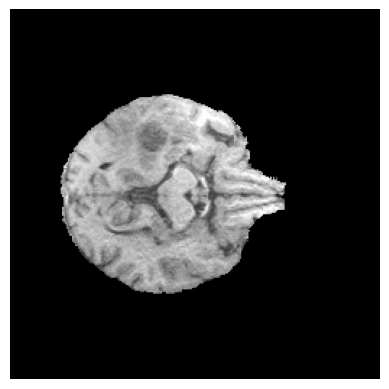

In [ ]:
sample_idx = 300

image, gt = dataset[sample_idx]  # image: (C, D, H, W), gt: (D, H, W)
slice = 104 # or 126

#Skew image


plt.imshow(image[0, :, :, slice_idx], cmap='gray')
plt.axis('off')
plt.show()